In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from scipy.stats import ttest_ind
import json
import os

# Set options

In [3]:
# for the metabolites the batch correction is not present and there are no NAN values, but many 0.0 values

THRESHOLD = 90
batch_corrected = False
zero_remove = False
scaler_term = 'minmax'
scaler = MinMaxScaler() if scaler_term=='minmax' else StandardScaler()

test_enc_name = '_BatchCor'+str(batch_corrected)+'_NanRem'+str(zero_remove)+'_'+str(scaler_term)

# Load config files

In [2]:
with open('data/paths.json','r') as f:
    paths = json.load(f)

data_path = paths["data_path"]

# Get data

In [4]:
df = pd.read_excel(os.path.join(data_path,"2022_12_Laezza_Bernabucci_Mouse_Brain_COMBINED_METABOLOMICS.xlsx"))
n_classes = len(np.unique(df['Metabolite']))
df.head()

,Sample Number,Sample Submission Date,Sample Name,Sex,Tissue weight\n(mg),Treatment,Tissue Type,PND,Litter,Metabolite,MRM Transition of each lipid species\n(Parent ion/Fragment ion),Metabolite used as Internal Standard,Retention Time\n(min),Peak Area of Metabolite,Peak Area of Internal Standard,Normalized Peak Area\n(Peak Area of Metabolite / (Peak Area of Internal Standard * Tisue weight))
0,1,09/2021,C20M1S,M,56,control,striatum,30,C20,Urea.1,61.0 / 44.0,L-Tryptophan.1.IS,1.959026,5.326877e+07,1.792767e+07,0.053059
1,1,09/2021,C20M1S,M,56,control,striatum,30,C20,Ethanolamine.1,62.1 / 44.1,L-Tryptophan.1.IS,9.962347,1.287801e+07,1.792767e+07,0.012827
2,1,09/2021,C20M1S,M,56,control,striatum,30,C20,Imidazole.1,69.0 / 42.2,L-Tryptophan.1.IS,2.478150,1.576080e+05,1.792767e+07,0.000157
3,1,09/2021,C20M1S,M,56,control,striatum,30,C20,Trimethylamine-N-oxide.1,76.0 / 58.1,L-Tryptophan.1.IS,4.874291,1.159692e+07,1.792767e+07,0.011551
4,1,09/2021,C20M1S,M,56,control,striatum,30,C20,Glycine.2,76.0 / 30.0,L-Tryptophan.1.IS,6.283526,4.631088e+06,1.792767e+07,0.004613


## Select normalized or unnormalized data

In [5]:
metadata = df.iloc[:,:11]
if batch_corrected:
    data = pd.concat([metadata, df.iloc[:,15]],axis=1)
else:
    data = pd.concat([metadata, df.iloc[:,15]],axis=1)
data.head()

,Sample Number,Sample Submission Date,Sample Name,Sex,Tissue weight\n(mg),Treatment,Tissue Type,PND,Litter,Metabolite,MRM Transition of each lipid species\n(Parent ion/Fragment ion),Normalized Peak Area\n(Peak Area of Metabolite / (Peak Area of Internal Standard * Tisue weight))
0,1,09/2021,C20M1S,M,56,control,striatum,30,C20,Urea.1,61.0 / 44.0,0.053059
1,1,09/2021,C20M1S,M,56,control,striatum,30,C20,Ethanolamine.1,62.1 / 44.1,0.012827
2,1,09/2021,C20M1S,M,56,control,striatum,30,C20,Imidazole.1,69.0 / 42.2,0.000157
3,1,09/2021,C20M1S,M,56,control,striatum,30,C20,Trimethylamine-N-oxide.1,76.0 / 58.1,0.011551
4,1,09/2021,C20M1S,M,56,control,striatum,30,C20,Glycine.2,76.0 / 30.0,0.004613


### We are selecting the subset of female just to test their distribution out

In [16]:
subset_to_control = data[data['Sample Name'].isin(['C63F3S','C63F4S','C63F5S','C20F1S','C21F1S','C11F1S'])]
subset_to_control['Sample Submission Date'] = LabelEncoder().fit_transform(subset_to_control['Sample Submission Date'])
subset_to_control.head()


/tmp/ipykernel_8474/1360262896.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_to_control['Sample Submission Date'] = LabelEncoder().fit_transform(subset_to_control['Sample Submission Date'])


,Sample Number,Sample Submission Date,Sample Name,Sex,Tissue weight\n(mg),Treatment,Tissue Type,PND,Litter,Metabolite,MRM Transition of each lipid species\n(Parent ion/Fragment ion),Normalized Peak Area\n(Peak Area of Metabolite / (Peak Area of Internal Standard * Tisue weight))
675,4,0,C20F1S,F,68,control,striatum,30,C20,Urea.1,61.0 / 44.0,0.056091
676,4,0,C20F1S,F,68,control,striatum,30,C20,Ethanolamine.1,62.1 / 44.1,0.009647
677,4,0,C20F1S,F,68,control,striatum,30,C20,Imidazole.1,69.0 / 42.2,0.000180
678,4,0,C20F1S,F,68,control,striatum,30,C20,Trimethylamine-N-oxide.1,76.0 / 58.1,0.012916
679,4,0,C20F1S,F,68,control,striatum,30,C20,Glycine.2,76.0 / 30.0,0.003496


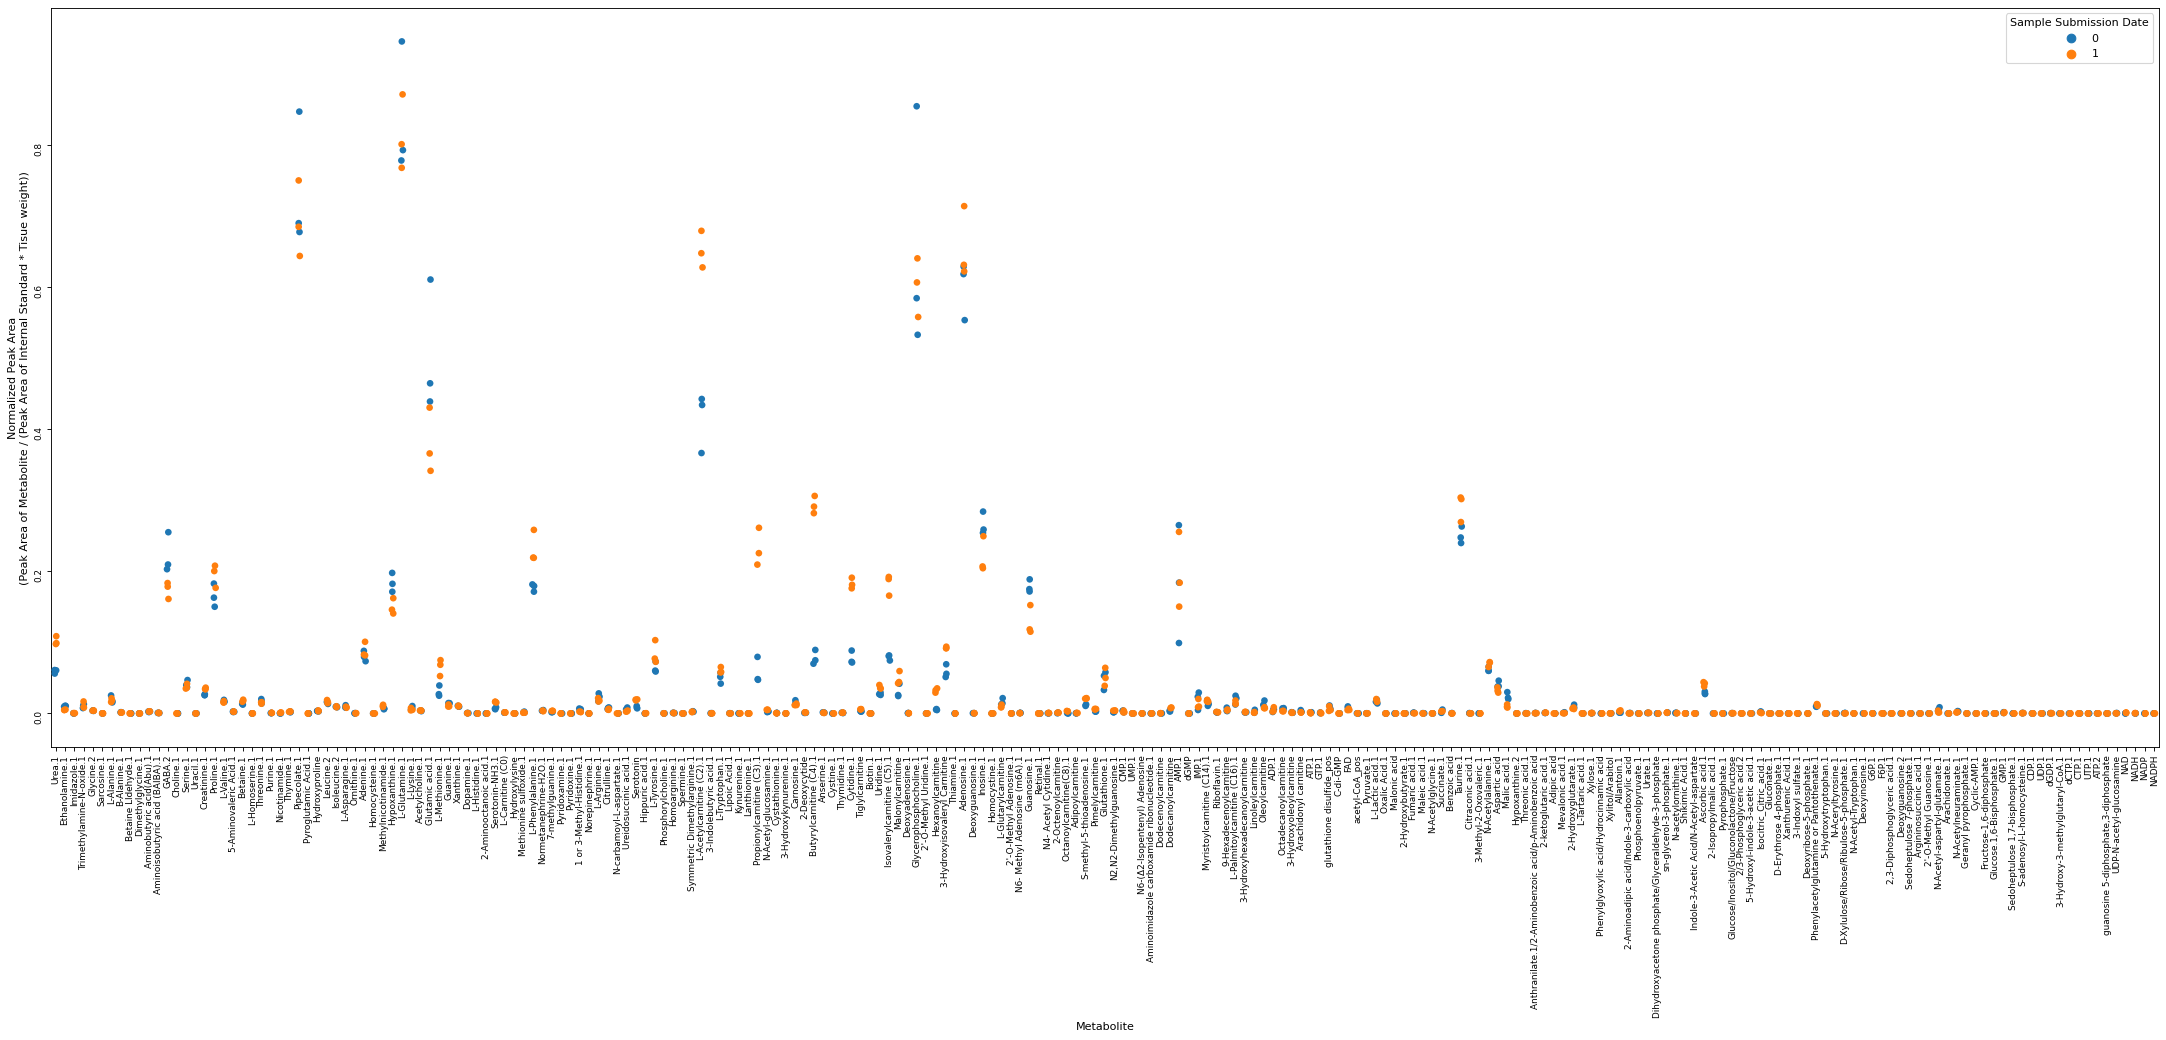

In [21]:
fig, ax = plt.subplots(figsize=(34,12), dpi=80)
ax.tick_params(rotation=90, labelsize=8)
ax = sns.stripplot(x = "Metabolite", y = "Normalized Peak Area\n(Peak Area of Metabolite / (Peak Area of Internal Standard * Tisue weight))", data=subset_to_control, hue="Sample Submission Date", size=6, edgecolor='black')


## Organize pivot table

In [87]:
data_pivot = data.pivot(index=['Sample Name', 'Sex', 'Treatment', 'PND', 'Tissue Type', 'Sample Submission Date'], columns='Metabolite', values=data.columns[-1])
tot_metabolites = data_pivot.shape[1] - 6

## Manage NaN

In [98]:
if zero_remove:
    data_stats = data_pivot.reset_index()[data_pivot.reset_index().iloc[:,6:] > 1E-5]
else:
    min_value = data.loc[data.loc[data['Normalized Peak Area\n(Peak Area of Metabolite / (Peak Area of Internal Standard * Tisue weight))']>0.0,'Normalized Peak Area\n(Peak Area of Metabolite / (Peak Area of Internal Standard * Tisue weight))'].idxmin(),'Normalized Peak Area\n(Peak Area of Metabolite / (Peak Area of Internal Standard * Tisue weight))']
    data_stats = data_pivot.reset_index() 
    data_stats.iloc[:,6:] = data_stats.iloc[:,6:] + 0.1*min_value
    
data_stats.head()
metabolites_ok = list(data_stats.columns[6:])

In [99]:
data_stats

Metabolite,Sample Name,Sex,Treatment,PND,Tissue Type,Sample Submission Date,1 or 3-Methyl-Histidine.1,2'-O-Methyl Adenosine.1,2'-O-Methyl Guanosine.1,2'-O-Methyl Uridine.1,...,Xanthurenic Acid.1,Xylitol/Arabitol,Xylose.1,acetyl-CoA_pos,dCTP.1,dGDP.1,dGMP,glutathione disulfide_pos,"guanosine 5-diphosphate,3-diphosphate",sn-glycerol-3-phosphate.1
0,C11F1C,F,control,30,cortex,09/2021,0.009659,0.000037,0.000019,0.000020,...,0.000087,0.000325,0.000423,0.000800,5.719417e-08,0.006579,5.719417e-08,5.719417e-08,5.719417e-08,0.001622
1,C11F1S,F,control,30,striatum,09/2021,0.006881,0.000030,0.000016,0.000029,...,0.000040,0.000129,0.000424,0.000159,5.719417e-08,0.000373,5.719417e-08,1.113616e-02,5.719417e-08,0.001251
2,C11M2C,M,control,30,cortex,09/2021,0.005360,0.000055,0.000020,0.000045,...,0.000039,0.000171,0.000391,0.000128,5.719417e-08,0.000311,5.719417e-08,4.932075e-03,5.719417e-08,0.000844
3,C11M4S,M,control,30,striatum,09/2021,0.004468,0.000037,0.000020,0.000019,...,0.000024,0.000119,0.000435,0.000157,5.719417e-08,0.000252,5.719417e-08,5.957752e-03,5.719417e-08,0.000834
4,C15M1S,M,control,30,striatum,11/2022,0.002412,0.000254,0.000036,0.000142,...,0.000154,0.000282,0.000477,0.001193,5.719417e-08,0.009962,5.719417e-08,5.719417e-08,5.719417e-08,0.002501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,T38F3S,F,deltamethrin,30,striatum,11/2022,0.003756,0.000048,0.000026,0.000033,...,0.000011,0.000172,0.000434,0.000135,5.719417e-08,0.000170,5.719417e-08,4.864852e-03,5.719417e-08,0.001229
68,T38M1S,M,deltamethrin,30,striatum,11/2022,0.002515,0.000047,0.000023,0.000031,...,0.000018,0.000154,0.000551,0.000216,5.719417e-08,0.000526,5.719417e-08,7.524959e-03,5.719417e-08,0.001187
69,T44M5C,M,deltamethrin,60,cortex,09/2021,0.007900,0.000048,0.000022,0.000029,...,0.000105,0.000207,0.000469,0.000829,5.719417e-08,0.001243,5.719417e-08,1.003485e-02,5.719417e-08,0.001960
70,T44M5S,M,deltamethrin,60,striatum,09/2021,0.004616,0.000137,0.000014,0.000020,...,0.000016,0.000091,0.000326,0.000042,5.719417e-08,0.000333,5.719417e-08,8.006859e-03,5.719417e-08,0.001207


## Encode batch

In [100]:
data_stats['Sample Submission Date'] = LabelEncoder().fit_transform(data_stats['Sample Submission Date'])
data_stats['Treatment'] = LabelEncoder().fit_transform(data_stats['Treatment'])
data_stats['Sample Submission Date'].unique()

array([0, 1])

## Log transform

In [101]:
data_np = data_stats.values[:,6:]
data_np = np.log(data_np.astype('float64'))
print(data_np.shape)

(72, 225)


## Visualize data distribution

In [102]:
data_stats

Metabolite,Sample Name,Sex,Treatment,PND,Tissue Type,Sample Submission Date,1 or 3-Methyl-Histidine.1,2'-O-Methyl Adenosine.1,2'-O-Methyl Guanosine.1,2'-O-Methyl Uridine.1,...,Xanthurenic Acid.1,Xylitol/Arabitol,Xylose.1,acetyl-CoA_pos,dCTP.1,dGDP.1,dGMP,glutathione disulfide_pos,"guanosine 5-diphosphate,3-diphosphate",sn-glycerol-3-phosphate.1
0,C11F1C,F,0,30,cortex,0,0.009659,0.000037,0.000019,0.000020,...,0.000087,0.000325,0.000423,0.000800,5.719417e-08,0.006579,5.719417e-08,5.719417e-08,5.719417e-08,0.001622
1,C11F1S,F,0,30,striatum,0,0.006881,0.000030,0.000016,0.000029,...,0.000040,0.000129,0.000424,0.000159,5.719417e-08,0.000373,5.719417e-08,1.113616e-02,5.719417e-08,0.001251
2,C11M2C,M,0,30,cortex,0,0.005360,0.000055,0.000020,0.000045,...,0.000039,0.000171,0.000391,0.000128,5.719417e-08,0.000311,5.719417e-08,4.932075e-03,5.719417e-08,0.000844
3,C11M4S,M,0,30,striatum,0,0.004468,0.000037,0.000020,0.000019,...,0.000024,0.000119,0.000435,0.000157,5.719417e-08,0.000252,5.719417e-08,5.957752e-03,5.719417e-08,0.000834
4,C15M1S,M,0,30,striatum,1,0.002412,0.000254,0.000036,0.000142,...,0.000154,0.000282,0.000477,0.001193,5.719417e-08,0.009962,5.719417e-08,5.719417e-08,5.719417e-08,0.002501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,T38F3S,F,1,30,striatum,1,0.003756,0.000048,0.000026,0.000033,...,0.000011,0.000172,0.000434,0.000135,5.719417e-08,0.000170,5.719417e-08,4.864852e-03,5.719417e-08,0.001229
68,T38M1S,M,1,30,striatum,1,0.002515,0.000047,0.000023,0.000031,...,0.000018,0.000154,0.000551,0.000216,5.719417e-08,0.000526,5.719417e-08,7.524959e-03,5.719417e-08,0.001187
69,T44M5C,M,1,60,cortex,0,0.007900,0.000048,0.000022,0.000029,...,0.000105,0.000207,0.000469,0.000829,5.719417e-08,0.001243,5.719417e-08,1.003485e-02,5.719417e-08,0.001960
70,T44M5S,M,1,60,striatum,0,0.004616,0.000137,0.000014,0.000020,...,0.000016,0.000091,0.000326,0.000042,5.719417e-08,0.000333,5.719417e-08,8.006859e-03,5.719417e-08,0.001207


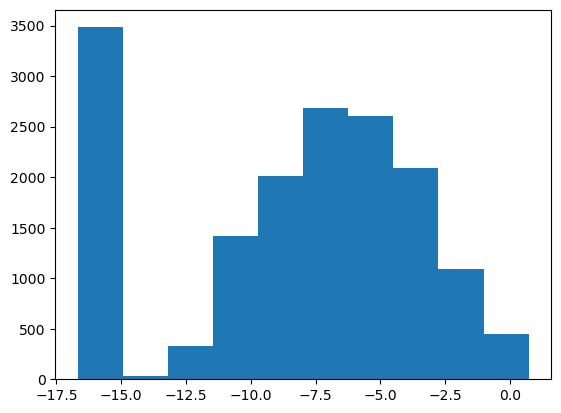

In [103]:
plt.figure()
plt.hist(data_np.flatten())
plt.show()

# Normalize data

In [104]:
data_norm = scaler.fit_transform(data_np)

## Visualize normalized data distribution

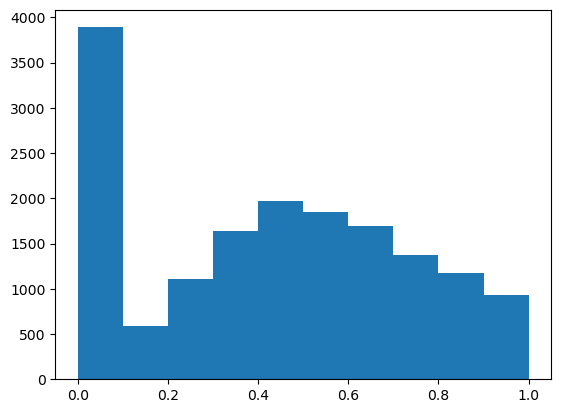

In [105]:
plt.figure()
plt.hist(data_norm.flatten())
plt.show()

# PCA

In [106]:
pca = PCA()
data_pca = pca.fit_transform(data_norm)
print(data_pca.shape)

(72, 72)


## Latent curve

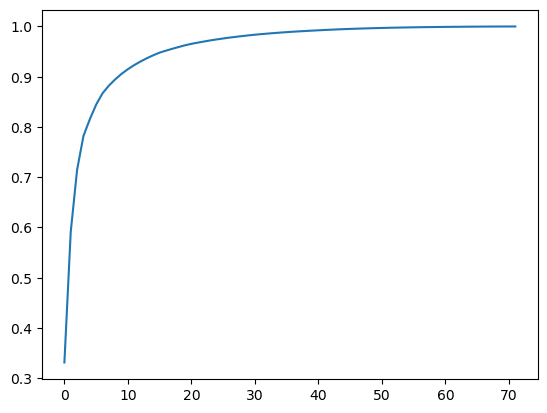

In [107]:
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.show()

# T-test

In [108]:
p_values = [
    [
        d,
        ttest_ind(data_pca[data_stats['Sample Submission Date']==0, d], data_pca[data_stats['Sample Submission Date']==1, d])[1],
        ttest_ind(data_pca[data_stats['Treatment']==0, d], data_pca[data_stats['Treatment']==1, d])[1],
    ]
    for d in range(data_pca.shape[1])
]
p_values = np.asarray(p_values)
print(p_values.shape)

(72, 3)


# Visualize data after PCA

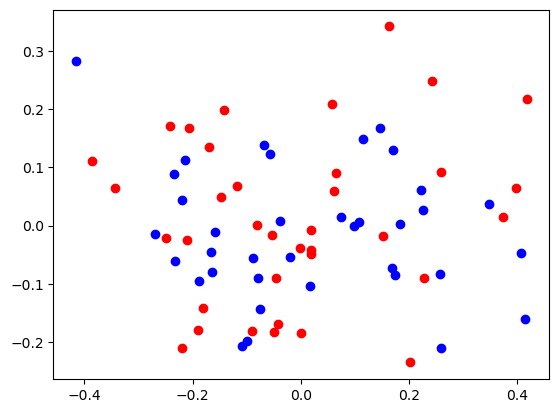

In [109]:
plt.scatter(data_pca[data_stats['Treatment']==0, 14], data_pca[data_stats['Treatment']==0, 21],c="red")
plt.scatter(data_pca[data_stats['Treatment']==1, 14], data_pca[data_stats['Treatment']==1, 21],c="blue")
plt.show()

# Isolate significant PCs

In [110]:
print(f'{np.sum(p_values[:,1]<0.05)} significant pc with respect to date')
print(f'{np.sum(p_values[:,2]<0.05)} significant pc with respect to date')
print(f'{np.sum((p_values[:,2]<0.05)*(p_values[:,1]<0.05))} significant pc with respect to both')

significant_pc = np.where(p_values[:,2]<0.05)[0]

3 significant pc with respect to date
6 significant pc with respect to date
1 significant pc with respect to both


# Isolate significant metabolites

In [111]:
significant_components = pca.components_[significant_pc,:]
print(significant_components.shape)
max_values = np.max(np.abs(significant_components), axis=0)
print(max_values.shape)

(6, 225)
(225,)


In [112]:
ths = np.percentile(np.abs(pca.components_.flatten()), THRESHOLD)
idx_significant_metabolites = np.where(max_values>ths)[0]
n_significant_metabolites = len(idx_significant_metabolites)
print(f'{n_significant_metabolites} ({n_significant_metabolites/tot_metabolites*100:.2f}% of original total) significant lipids found')
significant_metabolites = [metabolites_ok[i] for i in idx_significant_metabolites]

85 (38.81% of original total) significant lipids found


In [113]:
metabolites_classes = np.unique([metabolites_ok[i].split('(')[0] for i in idx_significant_metabolites])
print(f'{len(metabolites_classes)} ({len(metabolites_classes)/n_classes*100:.2f}% of original total) lipid classes found')
print(metabolites_classes)

85 (37.78% of original total) lipid classes found
["2'-O-Methyl Adenosine.1" "2'-O-Methyl Guanosine.1" '2-Hydroxybutyrate.1'
 '2-Octenoylcarnitine' '2-ketoglutaric acid.1'
 '3-Hydroxyisovaleryl Carnitine' '3-Hydroxykynurenine.1'
 '3-Indoxyl sulfate.1' '3-Methyl-2-Oxovaleric.1' 'Acetylcholine.1'
 'Adenine.1' 'Adenosine.1' 'Adipoylcarnitine' 'Ascorbic acid.1'
 'Aspartic acid' 'CDP.1' 'CMP.1' 'Citrulline.1' 'Cyclic-AMP.1'
 'Cystathionine.1' 'Cytidine.1' 'Deoxyadenosine.1' 'Deoxyguanosine.1'
 'Deoxyguanosine.2' 'Deoxyinosine.1' 'Dodecenoylcarnitine' 'Dopamine.1'
 'F6P.1' 'Fructose-1,6-diphosphate' 'Glucose.1,6-Bisphosphate.1'
 'Glucose/Inositol/Gluconolactone/Fructose' 'Glutathione.1'
 'Hippuric acid.1' 'Hydroxyproline' 'Hypoxanthine.1' 'IMP.1' 'Imidazole.1'
 'Inosine.1' 'Isovalerylcarnitine ' 'Kynurenine.1' 'L-Acetylcarnitine '
 'L-Alanine.1' 'L-Carnitine ' 'L-Glutamine.1' 'L-Glutarylcarnitine'
 'L-Lactic acid.1' 'L-Methionine.1' 'L-Phenylalanine.1' 'L-Tyrosine.1'
 'L-Valine.1' 'Leucine.2

In [114]:
date_pc = np.where(p_values[:,1]<0.05)[0]
significant_components = pca.components_[date_pc,:]
max_values = np.max(np.abs(significant_components), axis=0)

idx_significant_metabolites = np.where(max_values>ths)[0]
n_significant_metabolites = len(idx_significant_metabolites)
print(f'{n_significant_metabolites} ({n_significant_metabolites/tot_metabolites*100:.2f}% of original total) date dependent lipids found')
date_metabolites = [metabolites_ok[i] for i in idx_significant_metabolites]

86 (39.27% of original total) date dependent lipids found


## Save results

In [115]:
with open(os.path.join('results','significant_metabolites'+test_enc_name+'.txt'), 'w') as f:
    for l in significant_metabolites:
        f.write(l+'\n')

with open(os.path.join('results','date_metabolites'+test_enc_name+'.txt'), 'w') as f:
    for l in date_metabolites:
        f.write(l+'\n')

with open(os.path.join('results','significant_metabolite_classes'+test_enc_name+'.txt'), 'w') as f:
    for l in metabolites_classes:
        f.write(l+'\n')

### EXAMPLE WITH PARTIAL LEAST SQUARE - DA

In [132]:
from sklearn.cross_decomposition import PLSRegression
pls2_treatment = PLSRegression(n_components=72, scale = False)
pls2_date = PLSRegression(n_components=72, scale = False)
data_pls2_treatment = pls2_treatment.fit_transform(data_norm, data_stats['Treatment'].values)
data_pls2_date = pls2_date.fit_transform(data_norm, data_stats['Sample Submission Date'].values)


/home/ivan/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:305: UserWarning: Y residual is constant at iteration 71
  warnings.warn(f"Y residual is constant at iteration {k}")
/home/ivan/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:305: UserWarning: Y residual is constant at iteration 71
  warnings.warn(f"Y residual is constant at iteration {k}")


In [133]:
p_values_pls2 = [
    [
        d,
        ttest_ind(data_pls2_date[0][data_stats['Sample Submission Date']==0, d], data_pls2_date[0][data_stats['Sample Submission Date']==1, d])[1],
        ttest_ind(data_pls2_treatment[0][data_stats['Treatment']==0, d], data_pls2_treatment[0][data_stats['Treatment']==1, d])[1],
    ]
    for d in range(data_pls2_treatment[0].shape[1])
]
p_values_pls2 = np.asarray(p_values_pls2)
print(p_values_pls2.shape)

(72, 3)


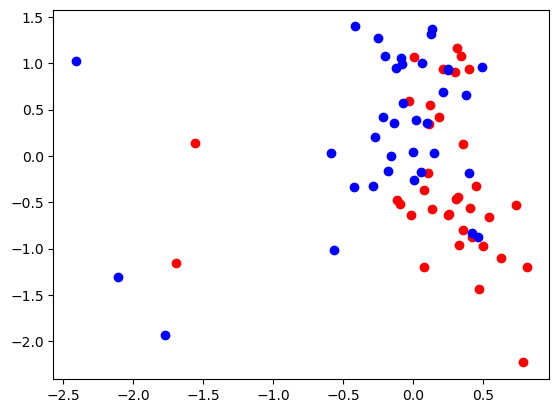

In [134]:
plt.scatter(data_pls2_treatment[0][data_stats['Treatment']==0, 1], data_pls2_treatment[0][data_stats['Treatment']==0, 2],c="red")
plt.scatter(data_pls2_treatment[0][data_stats['Treatment']==1, 1], data_pls2_treatment[0][data_stats['Treatment']==1, 2],c="blue")
plt.show()

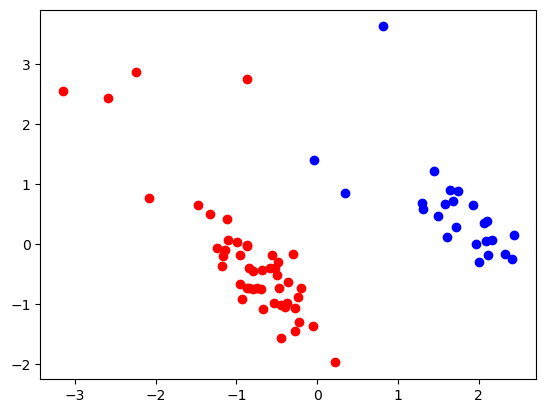

In [135]:
plt.scatter(data_pls2_date[0][data_stats['Sample Submission Date']==0, 0], data_pls2_date[0][data_stats['Sample Submission Date']==0, 1],c="red")
plt.scatter(data_pls2_date[0][data_stats['Sample Submission Date']==1, 0], data_pls2_date[0][data_stats['Sample Submission Date']==1, 1],c="blue")
plt.show()

In [136]:
print(f'{np.sum(p_values_pls2[:,1]<0.05)} significant pc with respect to date')
print(f'{np.sum(p_values_pls2[:,2]<0.05)} significant pc with respect to TREATMENT')
print(f'{np.sum((p_values_pls2[:,2]<0.05)*(p_values[:,1]<0.05))} significant pc with respect to both')

significant_pc_pls2_treatment = np.where(p_values_pls2[:,2]<0.05)[0]
significant_pc_pls2_date = np.where(p_values_pls2[:,1]<0.05)[0]
print(significant_pc_pls2_treatment)
print(significant_pc_pls2_date)

2 significant pc with respect to date
7 significant pc with respect to TREATMENT
3 significant pc with respect to both
[0 1 2 3 4 5 6]
[0 1]


In [137]:
significant_components_pls2_treatment = pls2_treatment.x_weights_.T[significant_pc_pls2_treatment,:]
max_values_pls2_treatment = np.max(np.abs(significant_components_pls2_treatment), axis = 0)

In [138]:
ths_pls2_treatment = np.percentile(np.abs(pls2_treatment.x_weights_.T.flatten()), THRESHOLD)

In [139]:
idx_significant_metabolites_pls2_treatment = np.where(max_values_pls2_treatment>ths_pls2_treatment)[0]
n_significant_metabolites_pls2_treatment = len(idx_significant_metabolites_pls2_treatment)
print(f'{n_significant_metabolites_pls2_treatment} ({n_significant_metabolites_pls2_treatment/tot_metabolites*100:.2f}% of original total) significant lipids found')
significant_metabolites_pls2_treatment = [metabolites_ok[i] for i in idx_significant_metabolites_pls2_treatment]

108 (49.32% of original total) significant lipids found


In [140]:
significant_components_pls2_date = pls2_date.x_weights_.T[significant_pc_pls2_date,:]
max_values_pls2_date = np.max(np.abs(significant_components_pls2_date), axis = 0)

In [141]:
ths_pls2_date = np.percentile(np.abs(pls2_date.x_weights_.T.flatten()), THRESHOLD)

In [142]:
idx_significant_metabolites_pls2_date = np.where(max_values_pls2_date>ths_pls2_date)[0]
n_significant_metabolites_pls2_date = len(idx_significant_metabolites_pls2_date)
print(f'{n_significant_metabolites_pls2_date} ({n_significant_metabolites_pls2_date/tot_metabolites*100:.2f}% of original total) significant lipids found')
significant_metabolites_pls2_date = [metabolites_ok[i] for i in idx_significant_metabolites_pls2_date]

52 (23.74% of original total) significant lipids found


In [143]:
metabolite_classes_pls2_treatment = np.unique([metabolites_ok[i].split('(')[0] for i in idx_significant_metabolites_pls2_date])
print(f'{len(metabolite_classes_pls2_treatment)} ({len(metabolite_classes_pls2_treatment)/n_classes*100:.2f}% of original total) lipid classes found')
print(metabolite_classes_pls2_treatment)

52 (23.11% of original total) lipid classes found
["2'-O-Methyl Adenosine.1" "2'-O-Methyl Guanosine.1"
 '3-Hydroxyoleoylcarnitine' '3-Indolebutyric acid.1' '3-Indoxyl sulfate.1'
 '7-methylguanine.1' '9-Hexadecenoylcarnitine' 'AMP.1' 'ATP.1'
 'Arachidonyl carnitine' 'Benzoic acid' 'Butyrylcarnitine ' 'CDP.1'
 'Citraconic acid.1' 'Cytidine.1' 'Ethanolamine.1' 'Fumaric acid.1'
 'GMP.1' 'Hexanoylcarnitine' 'Imidazole.1' 'L-Arginine.1' 'L-Lysine.1'
 'L-Methionine.1' 'Linoleylcarnitine' 'Maleic acid.1' 'Malic acid.1'
 'Methionine sulfoxide.1' 'Methylnicotinamide.1' 'Mevalonic acid.1'
 'N-Aceryltyrosine.1' 'N-Acetyl-glucosamine.1' 'N-acetylornithine.1'
 'N2,N2-Dimethylguanosine.1' 'NAD' 'NADH' 'NADP' 'Nicotinamide.1'
 'Octadecanoylcarnitine' 'Oleoylcarnitine' 'Ornithine.1'
 'Phosphoenolpyruvate.1' 'Phosphorylcholine.1' 'Propionylcarnitine '
 'Serotonin' 'Serotonin-NH3.1' 'Succinate.1' 'UDP-N-acetyl-glucosamine'
 'UDP.1' 'Uracil.1' 'Ureidosuccinic acid.1' 'dGDP.1'
 'glutathione disulfide_pos']

In [144]:
metabolite_classes_pls2_date = np.unique([metabolites_ok[i].split('(')[0] for i in idx_significant_metabolites_pls2_date])
print(f'{len(metabolite_classes_pls2_date)} ({len(metabolite_classes_pls2_date)/n_classes*100:.2f}% of original total) lipid classes found')
print(metabolite_classes_pls2_date)

52 (23.11% of original total) lipid classes found
["2'-O-Methyl Adenosine.1" "2'-O-Methyl Guanosine.1"
 '3-Hydroxyoleoylcarnitine' '3-Indolebutyric acid.1' '3-Indoxyl sulfate.1'
 '7-methylguanine.1' '9-Hexadecenoylcarnitine' 'AMP.1' 'ATP.1'
 'Arachidonyl carnitine' 'Benzoic acid' 'Butyrylcarnitine ' 'CDP.1'
 'Citraconic acid.1' 'Cytidine.1' 'Ethanolamine.1' 'Fumaric acid.1'
 'GMP.1' 'Hexanoylcarnitine' 'Imidazole.1' 'L-Arginine.1' 'L-Lysine.1'
 'L-Methionine.1' 'Linoleylcarnitine' 'Maleic acid.1' 'Malic acid.1'
 'Methionine sulfoxide.1' 'Methylnicotinamide.1' 'Mevalonic acid.1'
 'N-Aceryltyrosine.1' 'N-Acetyl-glucosamine.1' 'N-acetylornithine.1'
 'N2,N2-Dimethylguanosine.1' 'NAD' 'NADH' 'NADP' 'Nicotinamide.1'
 'Octadecanoylcarnitine' 'Oleoylcarnitine' 'Ornithine.1'
 'Phosphoenolpyruvate.1' 'Phosphorylcholine.1' 'Propionylcarnitine '
 'Serotonin' 'Serotonin-NH3.1' 'Succinate.1' 'UDP-N-acetyl-glucosamine'
 'UDP.1' 'Uracil.1' 'Ureidosuccinic acid.1' 'dGDP.1'
 'glutathione disulfide_pos']

In [145]:
unique_set_treatment = set(significant_metabolites_pls2_treatment).difference(set(significant_metabolites_pls2_date))
unique_list_treatment = list(unique_set_treatment)

In [146]:
with open(os.path.join('results','significant_metabolites_pls2_treatment'+test_enc_name+'.txt'), 'w') as f:
    for l in significant_metabolites_pls2_treatment:
        f.write(l+'\n')

In [147]:
with open(os.path.join('results','significant_metabolites_pls2_date'+test_enc_name+'.txt'), 'w') as f:
    for l in significant_metabolites_pls2_date:
        f.write(l+'\n')

In [148]:
with open(os.path.join('results','significant_metabolites_pls2_unique_treatment'+test_enc_name+'.txt'), 'w') as f:
    for l in unique_list_treatment:
        f.write(l+'\n')